In [6]:
%load_ext autoreload
%autoreload 3
from IPython import display
%matplotlib inline


In [7]:
import gymnasium as gym
from matplotlib import pyplot as plt

In [8]:
import os
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_util import make_vec_env
os.environ["PYGLET_HEADLESS"] = "true"
os.environ["PYGLET_HEADLESS_DEVICE"] = "0"

# %%
from envs.game_creator import get_game
from envs.miniworld.params import GameParams


Renderer Vendor: NVIDIA Corporation
Renderer Hardware: NVIDIA GeForce RTX 4090/PCIe/SSE2


# Test

In [9]:
game = get_game(name="miniworld_lidar", params=GameParams(
    map_fpath="../experiments/maps/map_13.txt",
    # map_fpath=None,
    ltl_task=None,
    # ltl_task=("until", "True", ("and", "a", ("until", "True", "b"))),
    prob=1
), render_mode="rgb_array", max_episode_steps=1500, do_transpose=False, edge_centric=True)

{'obs': array([15.55634919, 15.55634919, 15.55634919, 15.55634919, 15.55634919,
        3.6935375 , 15.55634919, 15.55634919, 15.55634919, 15.55634919,
       15.55634919, 15.55634919,  2.63244752, 15.55634919,  8.74472218,
       15.55634919, 15.55634919, 15.55634919, 15.55634919, 15.55634919,
       15.55634919, 15.55634919,  6.81371905, 15.55634919, 15.55634919,
       15.55634919, 15.55634919, 15.55634919, 15.55634919,  3.6935375 ,
       15.55634919,  2.88416049, 15.55634919, 15.55634919, 15.55634919,
       15.55634919, 15.55634919,  3.6935375 , 15.55634919,  5.86249966,
       15.55634919, 15.55634919, 15.55634919,  2.21378578, 15.55634919,
        3.6935375 , 15.55634919, 15.55634919, 15.55634919, 15.55634919,
       15.55634919, 15.55634919, 15.55634919, 15.55634919, 15.55634919,
        6.03306181]), 'out_edge_goal': array([0., 0., 1., 0., 0., 0.])} {'agent_init_loc': (3.1582465711591, 1.4927668787292792), 'map_size': (11, 11), 'true_props': '', 'edge_goal': ('!c', 'c'), 'loc

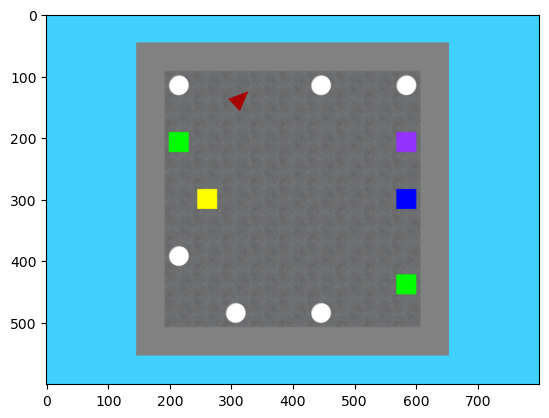

In [10]:
obs, info = game.reset()
img = plt.imshow(game.render())
print(obs, info)

obs {'obs': array([15.55634919, 15.55634919, 15.55634919, 15.55634919, 15.55634919,
        3.5617686 , 15.55634919, 15.55634919, 15.55634919, 15.55634919,
       15.55634919, 15.55634919,  2.48432502, 15.55634919,  8.74122535,
       15.55634919, 15.55634919, 15.55634919, 15.55634919, 15.55634919,
       15.55634919, 15.55634919,  6.85477194, 15.55634919, 15.55634919,
       15.55634919, 15.55634919, 15.55634919, 15.55634919,  3.5617686 ,
       15.55634919,  3.00981819, 15.55634919, 15.55634919, 15.55634919,
       15.55634919, 15.55634919, 15.55634919,  7.96965066,  5.97994443,
       15.55634919, 15.55634919, 15.55634919,  2.13489796, 15.55634919,
        3.5617686 , 15.55634919, 15.55634919, 15.55634919, 15.55634919,
       15.55634919, 15.55634919, 15.55634919, 15.55634919, 15.55634919,
        6.11341286]), 'out_edge_goal': array([0., 0., 1., 0., 0., 0.])}
rew 0.0 term False trunc False info {'agent_init_loc': (None, None), 'map_size': (None, None), 'true_props': '', 'edge_goal'

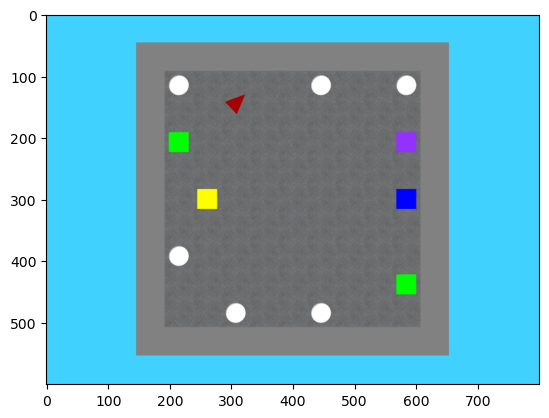

In [11]:
obs, rew, term, trunc, info = game.step(3)
img = plt.imshow(game.render())
print("obs", obs)
print("rew", rew, "term", term, "trunc", trunc, "info", info)

# Run

In [12]:

# %%
envs = make_vec_env(lambda: 
                    get_game(name="miniworld_simp_lidar", 
    params=GameParams(
        map_fpath="../experiments/maps/map_13.txt",
        # map_fpath=None,
        ltl_task=None,
        max_edge_props=1,
        prob=1), 
    max_episode_steps=3000, do_transpose=False, edge_centric=True)
, 16)

In [13]:
envs.reset()

OrderedDict([('obs',
              array([[1.        , 1.        , 1.        , 1.        , 1.        ,
                      0.42416647, 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 0.42416647, 1.        ,
                      0.37963805, 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 0.19272767, 1.        ,
                      1.        , 1.        , 1.        , 0.14767106, 1.        ,
                      0.5421236 , 1.        , 1.        , 1.        , 0.10101972,
                      1.        , 1.        , 1.        , 1.        , 0.45597816,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      0.42416647, 0.54445153, 1.        , 0.08453131, 1.        ,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        ],
                     [1.        , 1.      

In [14]:
from torch import nn
import torch
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [15]:
class CustomCombinedExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict):
        super().__init__(observation_space, features_dim=1)

        extractors = {}

        total_concat_size = 0
        # We need to know size of the output of this extractor,
        # so go over all the spaces and compute output feature sizes
        for key, subspace in observation_space.spaces.items():
            if key == 'obs':
                # Run through a simple MLP
                extractors[key] = nn.Linear(subspace.shape[0], 1024)
                total_concat_size += 1024

        self.extractors = nn.ModuleDict(extractors)

        # Update the features dim manually
        self._features_dim = total_concat_size

    def forward(self, observations) -> torch.Tensor:
        encoded_tensor_list = []

        # self.extractors contain nn.Modules that do all the processing.
        for key, extractor in self.extractors.items():
            encoded_tensor_list.append(extractor(observations[key]))
        # Return a (B, self._features_dim) PyTorch tensor, where B is batch dimension.
        return torch.cat(encoded_tensor_list, dim=1)

In [16]:
# %%
# model = PPO("CnnPolicy", game, 
#             verbose=1)
model = PPO("MultiInputPolicy", 
            envs, 
            policy_kwargs=dict(
                activation_fn=nn.ReLU, 
                net_arch=[1024, 1024, 256], 
                features_extractor_class=CustomCombinedExtractor,
            ),
            verbose=1,
            # batch_size=1024,
            # gamma=0.95
            # batch_size=1024,
            # ent_coef=0.003,
            # gamma=0.995
    )
model.learn(total_timesteps=10000000)
model.save("ppo_cartpole")


Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 612      |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 1497     |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 32768    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.71e+03     |
|    ep_rew_mean          | 0.643        |
| time/                   |              |
|    fps                  | 1190         |
|    iterations           | 2            |
|    time_elapsed         | 55           |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0101264715 |
|    clip_fraction        | 0.089        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | -1.26       

KeyboardInterrupt: 

In [17]:
envs.reset()

OrderedDict([('obs',
              array([[1.        , 0.17293443, 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 0.17293443,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      0.45708022, 0.48824438, 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 0.5044122 ,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      0.11019905, 1.        , 0.6271885 , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 0.27694297,
                      1.        , 0.17293443, 0.07264441, 1.        , 1.        ,
                      1.        , 1.        , 1.        , 0.5471244 , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        ],
                     [1.        , 1.      

# 2 Props

In [18]:
# %%
envs2 = make_vec_env(lambda: 
                    get_game(name="miniworld_simp_lidar", 
    params=GameParams(
        map_fpath="../experiments/maps/map_13.txt",
        # map_fpath=None,
        ltl_task=None,
        max_edge_props=2,
        prob=1), 
    max_episode_steps=1500, do_transpose=False, edge_centric=True)
, 16)

In [20]:
envs2.reset()

OrderedDict([('obs',
              array([[1.        , 0.4113056 , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 0.4113056 ,
                      1.        , 0.39123705, 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 0.20721743,
                      1.        , 1.        , 1.        , 1.        , 0.12774278,
                      1.        , 0.5382481 , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 0.45914885,
                      1.        , 1.        , 1.        , 0.10865097, 1.        ,
                      1.        , 0.4113056 , 0.5342446 , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 0.10413031, 1.        , 1.        ,
                      1.        ],
                     [1.        , 1.      

In [21]:
# %%
# model = PPO("CnnPolicy", game, 
#             verbose=1)
model = PPO("MultiInputPolicy", 
            envs2, 
            policy_kwargs=dict(
                activation_fn=nn.ReLU, 
                net_arch=[1024, 1024, 256], 
                features_extractor_class=CustomCombinedExtractor,
            ),
            verbose=1,
            # batch_size=1024,
            # gamma=0.95
            # batch_size=1024,
            # ent_coef=0.003,
            # gamma=0.995
    )
model.learn(total_timesteps=1000000)
model.save("ppo2")


Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 730      |
|    ep_rew_mean     | 0.441    |
| time/              |          |
|    fps             | 1521     |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 32768    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 847         |
|    ep_rew_mean          | 0.419       |
| time/                   |             |
|    fps                  | 1212        |
|    iterations           | 2           |
|    time_elapsed         | 54          |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.012810854 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.64       |
|    learnin